# Implementation of Policy Gradients with Direct Parameterization

#### *pymdptoolbox* is a python library from which MDP examples can be imported </br>
##### Documentation of *pymdptoolbox* : https://pymdptoolbox.readthedocs.io/en/latest/api/mdptoolbox.html

In [2]:
!pip install pymdptoolbox   #Install pymdptoolbox within the code

#   

#### *cvxopt* is a convex optimization library in python </br>
##### Documentation of *cvxopt (for quadratic optimization problem)* : https://cvxopt.org/examples/tutorial/qp.html

In [1]:
import mdptoolbox.example
import numpy as np
import sys
import time
import warnings
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import os
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')

In [2]:
class HiddenPrints:       #To suppress print statements during execution of library function
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Class MarkovDP 

In [3]:
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)State Space
4)Action Space
5)Transition probability matrix of size (a,s,s)
6)Reward matrix (a,s,s)
'''
class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        
# The function below initializes transition probability matrix and rewards marks 

    def initialize_mdp(self):      
        np.random.seed(0)        #for reproducibility 
        self.transitions, self.rewards = mdptoolbox.example.rand(self.num_state,self.num_action)
        self.rewards = np.random.rand(self.num_action,self.num_state,self.num_state)

## Direct Parameterization for policy : Initialized to uniformly distributed policy

In [4]:
def policy(s,a):
    pi = np.ones((s,a)) / a   #Policy Initialization
    return pi   

## Find transition matrix P(s'|s) under policy pi

### P (s'| s) under policy $\pi$ --> 
### $\Sigma$<sub>a~A</sub> $\pi$(a,s) p(s' | s,a)

In [5]:
def P_matrix(env,pi):
    
    # Compute Transition probabilities P(s,s') using P(s'| s,a ) and pi( a|s ) : Matrix of size |s| x |s|
    P=np.empty((env.num_state,env.num_state),dtype=float)
    P=np.multiply(np.reshape(pi[:,0],(-1,1)),env.transitions[0][:][:])
    for a in range(1,env.num_action):
        P=P+np.multiply(np.reshape(pi[:,a],(-1,1)),env.transitions[a][:][:])
    return P
        

## Find d<sup>$\pi\$</sup>(s) : discounted transition probability

In [6]:
def d_pi_s(env,P,gamma,s):
    e_s=np.zeros((env.num_state,1))  
    e_s[s]=1  
    i= np.identity(env.num_state)- gamma*(P)
    d= (1-gamma) * np.dot(np.linalg.inv(i),e_s)
    return d

## Projection operator : reduced to a quadratic optimization problem
### Objective :
#### Min $\Sigma$ (x(i) - c(i))<sup>2</sup> , where 
#### $x(i) \in (0,1)$ and
#### c = [c1,c2,c3..] is the vector to be projected

In [7]:
def projection(env,x):
    P = 2*matrix(np.identity(env.num_action))
    q = -2*matrix(x)
    G = -1*matrix(np.identity(env.num_action))
    h = matrix(np.zeros(env.num_action))
    A = matrix(np.ones(env.num_action), (1,env.num_action))
    b = matrix(1.0)
    with HiddenPrints():
        sol=solvers.qp(P, q, G, h, A, b)
    proj= np.reshape(np.array(sol['x']),(1,-1))
    return proj


## Policy Evaluation and Policy Iteration function

In [8]:
# Policy Evaluation Function
def evaluate_policy(env, pi, gamma, theta):
    V = np.zeros((env.num_state,1))
    while True:
        delta = 0
        for s in env.states:
            v = V[s].copy()
            V=update_v_policy(env, V, pi, s, gamma)    #bellman update 
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V


# Bellman Update function
def update_v_policy(env, V, pi, s, gamma):
    sum=0
    for a in env.actions:
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        sum=sum+pi[s][a]*(np.sum(np.multiply(transitions,(rewards+(gamma*V)))))
    V[s]=sum
    return V

# Function that chooses the greedy action for a particular state 's'
def choose_best_action(env, V, pi, s, gamma):
    q=np.empty((env.num_action,1),dtype=float)
    for a in env.actions:
        pi[s][a]=0
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        q[a]=np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
    action=np.argmax(q)        #Choose greedy action
    pi[s][action]=1            #Update Policy


#Policy Improvement step
def improve_policy(env, V, pi, gamma):
    policy_stable = True        # If policy_stable == True : Policy need not be updated anymore
    for s in env.states:
        old = pi[s].copy()
        choose_best_action(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old): 
            policy_stable = False
    return pi, policy_stable

#Policy Iteration
def policy_iteration(env, gamma, theta):
    V = np.zeros((env.num_state,1))          #Initialize Value function vector : [0,0,0...0]
    pi = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, pi, gamma, theta)          #Policy Evaluation step
        pi, policy_stable = improve_policy(env, V, pi, gamma)  #Policy Iteration step
    return V, pi

## Gradient Calculation

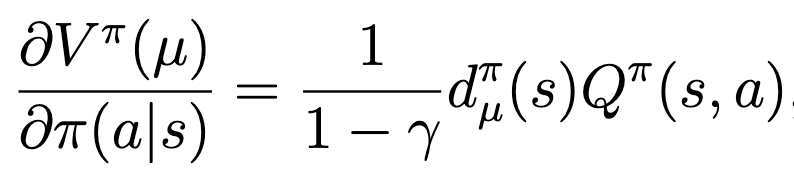

In [2]:
def grad(env,gamma,rho,pi,theta):
    V_grad= np.empty((env.num_state,env.num_action),dtype=float)
    P=P_matrix(env,pi)
    V=evaluate_policy(env, pi, gamma, theta)
    for s in env.states:
        d=d_pi_s(env,P,gamma,s)
        d_rho= np.dot(rho,d)
        for a in env.actions:
            transitions = np.reshape(env.transitions[a][s][:],(-1,1))
            rewards = np.reshape(env.rewards[a][s][:],(-1,1))
            q=np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
            V_grad[s][a]= (d_rho*q)/(1-gamma)  #Compute gradient for (s,a)
    
    return V_grad
            
        

## Policy Update

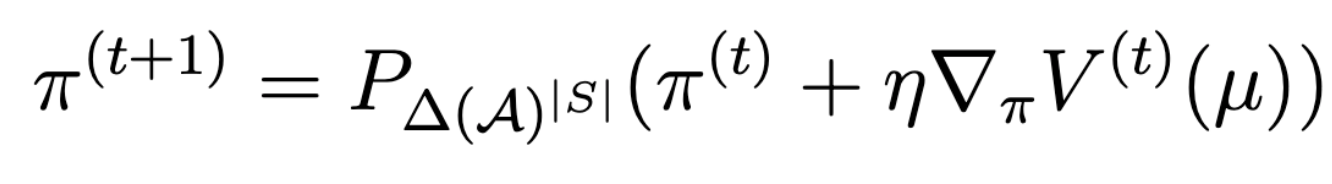

In [3]:
def policy_gradient(env,gamma,theta,rho,iterations,learning_rate,V_rho_optimal):
    pi = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    V = np.zeros((env.num_state,1))          #Initialize Value function vector : [0,0,0...0]
    min_list=list()
    min_t = (V_rho_optimal-np.dot(rho,V)[0]) #Save value function history to observe the convergence
    min_list.append(min_t)
    for i in range(0,iterations):
        V_grad=grad(env,gamma,rho,pi,theta) #Compute gradient
        for s in env.states:
            pi_update= pi[s]+ learning_rate * V_grad[s] #update policy parameters
            pi[s]= projection(env,pi_update) 
        V=evaluate_policy(env, pi, gamma, theta) 
        min_t=min(min_t,(V_rho_optimal-np.dot(rho,V)[0]))
        min_list.append(min_t)
    return pi,V,min_list
        

## Plot log(min(V<sup>*</sup> - V<sup>t</sup>)) vs log(t)

In [11]:
def plot_log(min_list,iterations):
    
    x=np.log(np.array(range(1,iterations)))
    y=np.log(np.array(min_list)[2:])
    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('log(t)', fontsize=12)
    plt.ylabel('log(min(V_opt-V(t)))', fontsize=12)
    plt.plot(x,y,color='blue', label='Policy Iteration') 
    #plt.title(title,fontsize=12)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()

In [12]:
def plot_antilog(min_list,iterations):
    
    x=(np.array(range(1,iterations)))
    y=np.log(np.array(min_list)[2:])
    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('t', fontsize=12)
    plt.ylabel('log(min(V_opt-V(t)))', fontsize=12)
    plt.plot(x,y,color='blue', label='Policy Iteration') 
    #plt.title(title,fontsize=12)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()

# Example 1 (s,a)=(3,2)

In [51]:
'''
Define an MDP Environment : Insantiate Class
    Number of states : s
    Number of actions : a
'''

s=3
a=2
env= MarkovDP(s,a)      #Define an MDP Environment : Insantiate Class
env.initialize_mdp()    #Define P and R


## Run Policy Iteration to find optimal V<sup>*</sup>($\rho\$)

In [58]:
gamma = 0.9       #Discount rate
theta = 0.0001    #A small positive number
iterations=10000
rho= np.ones(env.num_state)/env.num_state
learning_rate=(1-gamma)**3/((2*gamma)*env.num_action)

start_time = time.time()
V_optimal_policy,pi_optimal_policy=policy_iteration(env, gamma, theta)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.029594898223876953 seconds ---


In [59]:
print('The optimal value function vector is:')
print(V_optimal_policy)
V_rho_optimal = np.dot(rho,V_optimal_policy)[0]

The optimal value function vector is:
[[5.15741473]
 [4.17514917]
 [4.59557916]]


## Run Policy Gradient

In [ ]:
pi_optimal,V_optimal,min_list=policy_gradient(env,gamma,theta,rho,iterations,learning_rate,V_rho_optimal)

## Plot

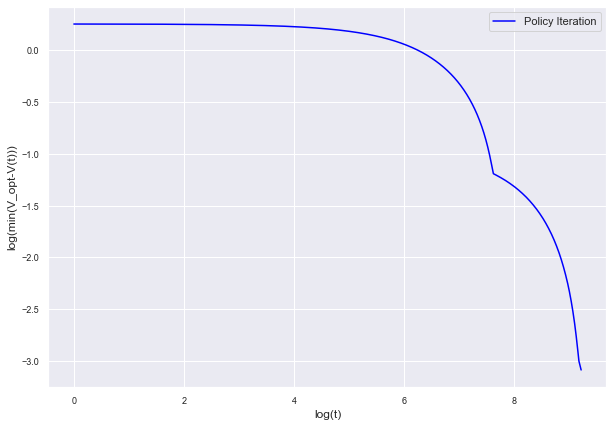

In [68]:
plot_log(min_list,iterations)

In [69]:
pi_optimal

array([[3.19644760e-03, 9.96803552e-01],
       [1.74807220e-01, 8.25192780e-01],
       [9.99704874e-01, 2.95125937e-04]])

In [70]:
pi_optimal_policy

array([[0., 1.],
       [0., 1.],
       [1., 0.]])

In [71]:
slope, intercept = np.polyfit(np.log(np.array(range(1,iterations))), np.log(np.array(min_list)[2:]), 1)

In [72]:
slope

-0.7548098315198325

# Example 2 (s,a)=(4,3)

In [75]:
'''
Define an MDP Environment : Insantiate Class
    Number of states : s
    Number of actions : a
'''

s=4
a=3
env= MarkovDP(s,a)      #Define an MDP Environment : Insantiate Class
env.initialize_mdp()    #Define P and R


## Run Policy Iteration to find optimal V<sup>*</sup>($\rho\$)

In [76]:
gamma = 0.9       #Discount rate
theta = 0.0001    #A small positive number
iterations=10000
rho= np.ones(env.num_state)/env.num_state
learning_rate=(1-gamma)**3/((2*gamma)*env.num_action)

start_time = time.time()
V_optimal_policy,pi_optimal_policy=policy_iteration(env, gamma, theta)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.06133389472961426 seconds ---


In [77]:
print('The optimal value function vector is:')
print(V_optimal_policy)
V_rho_optimal = np.dot(rho,V_optimal_policy)[0]

The optimal value function vector is:
[[5.89441735]
 [6.1322653 ]
 [5.9855203 ]
 [6.00462619]]


## Run Policy Gradient

In [78]:
pi_optimal,V_optimal,min_list=policy_gradient(env,gamma,theta,rho,iterations,learning_rate,V_rho_optimal)

## Plot

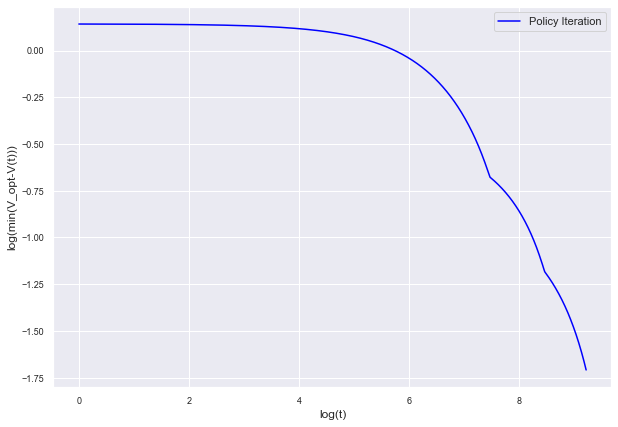

In [79]:
plot_log(min_list,iterations)

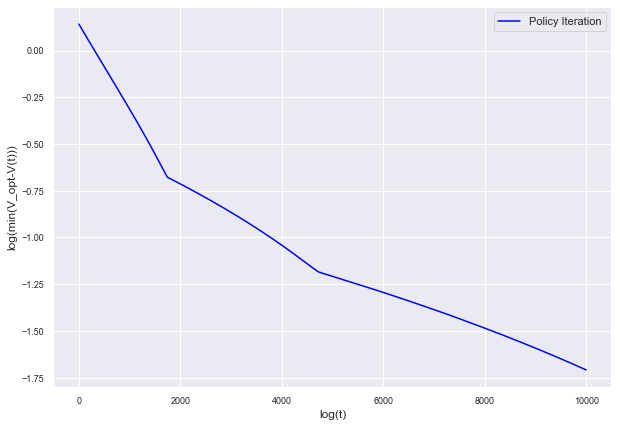

In [88]:
plot_antilog(min_list,iterations)

In [80]:
pi_optimal

array([[3.15179682e-01, 3.70287836e-04, 6.84450031e-01],
       [2.68222156e-03, 8.62031989e-01, 1.35285789e-01],
       [3.71449238e-01, 1.10695901e-01, 5.17854861e-01],
       [1.58550000e-01, 3.63239554e-01, 4.78210446e-01]])

In [81]:
pi_optimal_policy

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

# Example 3 (s,a)=(2,2)

In [13]:
'''
Define an MDP Environment : Insantiate Class
    Number of states : s
    Number of actions : a
'''

s=2
a=2
env= MarkovDP(s,a)      #Define an MDP Environment : Insantiate Class
env.initialize_mdp()    #Define P and R


## Run Policy Iteration to find optimal V<sup>*</sup>($\rho\$)


In [14]:
gamma = 0.9       #Discount rate
theta = 0.0001    #A small positive number
iterations=500
rho= np.ones(env.num_state)/env.num_state
learning_rate=0.02     #(1-gamma)**3/((2*gamma)*env.num_action)

start_time = time.time()
V_optimal_policy,pi_optimal_policy=policy_iteration(env, gamma, theta)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.013588905334472656 seconds ---


In [15]:
print('The optimal value function vector is:')
print(V_optimal_policy)
V_rho_optimal = np.dot(rho,V_optimal_policy)[0]

The optimal value function vector is:
[[4.9344773 ]
 [4.89569503]]


## Run Policy Gradient

In [16]:
pi_optimal,V_optimal,min_list=policy_gradient(env,gamma,theta,rho,iterations,learning_rate,V_rho_optimal)

## Plot

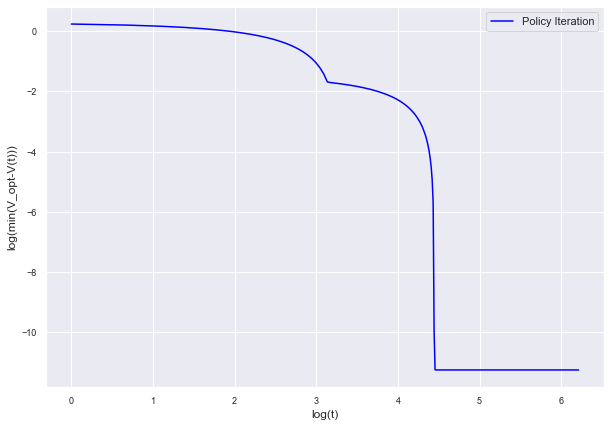

In [18]:
plot_log(min_list,iterations)

In [19]:
pi_optimal_policy

array([[0., 1.],
       [1., 0.]])

In [20]:
pi_optimal

array([[4.03092872e-06, 9.99995969e-01],
       [9.99994628e-01, 5.37221035e-06]])

In [21]:
slope, intercept = np.polyfit(np.log(np.array(range(1,60))), np.log(np.array(min_list)[2:61]), 1)

In [22]:
slope

-0.9022690868003425

In [23]:
np.log(60)

4.0943445622221